## 安装依赖包

In [1]:
%pip install diffusers transformers xformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.0 MB/s eta 0:00:00


In [2]:
%pip install opencv-contrib-python
%pip install controlnet_aux

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 23.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 生成边缘检测图

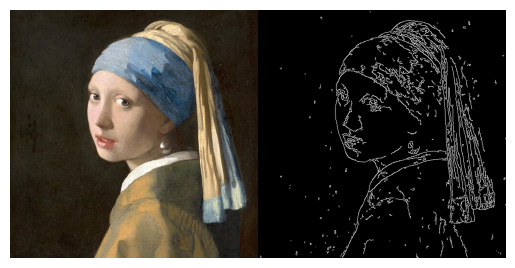

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers.utils import load_image
from PIL import Image

image_file = "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
original_image = load_image(image_file)

def get_canny_image(original_image, low_threshold=100, high_threshold=200):
  image = np.array(original_image)

  image = cv2.Canny(image, low_threshold, high_threshold)
  image = image[:, :, None]
  image = np.concatenate([image, image, image], axis=2)
  canny_image = Image.fromarray(image)
  return canny_image

canny_image = get_canny_image(original_image)

def display_images(image1, image2):
  # Combine the images horizontally
  combined_image = Image.new('RGB', (image1.width + image2.width, max(image1.height, image2.height)))
  combined_image.paste(image1, (0, 0))
  combined_image.paste(image2, (image1.width, 0))
  # Display the combined image
  plt.imshow(combined_image)
  plt.axis('off')
  plt.show()


display_images(original_image, canny_image)


## 配置ControlNet的Pipeline

In [5]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## 画图

In [15]:
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Audrey Hepburn", "Elizabeth Taylor", "Scarlett Johansson", "Taylor Swift"]]
generator = [torch.Generator(device="cpu").manual_seed(42) for i in range(len(prompt))]
output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=40,
    generator=generator,
)

  0%|          | 0/40 [00:00<?, ?it/s]

## 显示图片

In [13]:
def draw_image_grids(images, rows, cols):
  # Create a rows x cols grid for displaying the images
  fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

  for row in range(rows):
    for col in range(cols):
      axes[row, col].imshow(images[col + row * cols])
  for ax in axes.flatten():
      ax.axis('off')
  # Display the grid
  plt.show()

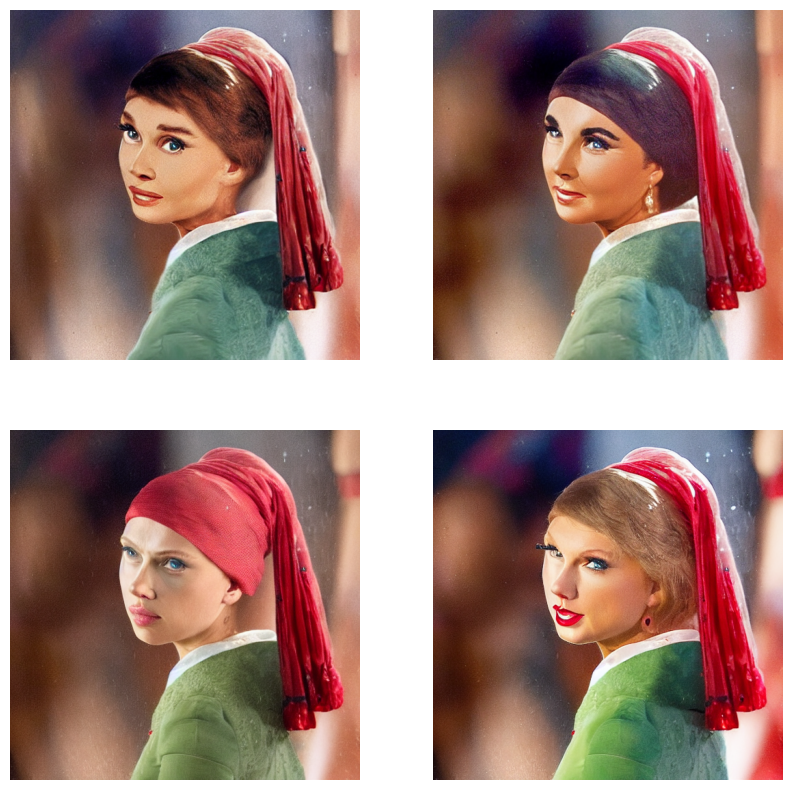

In [16]:
draw_image_grids(output.images, 2, 2)